# Graph measures

This script is used to:

1. Threshold raw beta series correlation matrices.
2. Calculate relevant graph metrics.

### Thresholding

Correlation matrices thresholding involves two-step process. First, statistical thresholding is applied on the group level. Matrices for all subjects, both task conditions and both prediction error signs are stacked together. For each connection, two-side t-test against 0 for connection strength is performed. Associated p-values are FDR corrected with specified `alpha_fdr` significance threshold to retain only strongest positive and negative connections. Second, remaining negative connections are removed from analysis. This seems viable since beta-serier correlation matrices are biased towards positive correlation and after typical statistical thresholding only ~10% (for `alpha_fdr=1e-8`).

> Note that during statistical thresholding some subjects are excluded based on excessive motion or acquisition failure. However, threshold is then applied to all matrices, so graph measures are caluclated on entire dataset. Relevant exclusion is performed during the last step of statistical analysis of graph measures.

### Graph metrics

Graph measures related to modularity are calculated. First, community structure is discovered using `community_louvain` algorithm for undirected, weighted networks with positive connections. Canonical **modularity** quality function is used throughout the search. Module size is controlled by the `louvain_gamma` resolution parameter (default 1). Search is conducted `louvain_reps` times and the division with highest score is stored as a representative for a network. Then node-level measures of centrality – **within-module degree z-score** and **participation coeffiecient** (measuring diversity of intermodular connections) are calculated for each network.

### File structure

Each statistical threshold has its own directory names `fdrthr_<statistical_threshold_value>` under atlas-specific directory in `bsc` directory. Within threshold-specific directories there can be different directories for specific values of louvain gamma parameter named `gamma_<louvain_gamma_value>`. Aggregated graph measures are stored in gamma-specific direcotries as numpy arrays (e.g. `z_aggregated` for within-module degree z-score).

```
<atlas_name>
├── corrmats_aggregated.json
├── corrmats_aggregated.npy
├── fdrthr_<statistical_threshold_value>
│   ├── gamma_<louvain_gamma_value>
│   │   ├── m_aggregated.npy
│   │   ├── p_aggregated.npy
│   │   ├── q_aggregated.npy
│   │   └── z_aggregated.npy
...
│   └── pvalues_mask.npy
└── roi_table_filtered.csv
```

In [1]:
import json
import os
from os.path import join
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from bct.algorithms.modularity import community_louvain
from bct.algorithms.clustering import clustering_coef_wu
from bct.algorithms.reference import randmio_und_signed
from bct.algorithms.centrality import module_degree_zscore, participation_coef
from bct.algorithms.distance import efficiency_wei
from dn_utils.plotting import plot_matrix
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_root = os.environ.get('DECIDENET_PATH')

path_derivatives = join(path_root, 'data/main_fmri_study/derivatives')
path_sourcedata = join(path_root, 'data/main_fmri_study/sourcedata') 

path_beh = join(path_sourcedata, 'behavioral')
path_bsc = join(path_derivatives, 'bsc')
path_nistats = join(path_derivatives, 'nistats')
path_parcellations = join(path_derivatives, 'parcellations')

path_corrmats = join(path_bsc, 'corrmats')

In [3]:
def perc_connections(mats, rule, non_network_dims=[]):
    '''...
    
    Args:
        mats: 
            Networks...
        rule (function)
            ...
        non_networks_dims
    '''
    # Calculate network dimensions
    network_dims = set(range(len(mats.shape))) - set(non_network_dims)
    n_rois = [mats.shape[dim] for dim in network_dims]
    if len(n_rois) != 2 or n_rois[0] != n_rois[1]:
        raise ValueError('wrong network dimensions')
    n_rois = n_rois[0]

    n_connections_rule = np.sum(rule(mats))
    n_connections_all = (np.prod([mats.shape[dim] for dim in non_network_dims]) 
                         * n_rois * (n_rois + 1))
    return n_connections_rule / n_connections_all

## Settings

In [4]:
atlas = 'combined_roi'

# Thresholding
alpha_fdr = 1e-0

# Modularity
louvain_gamma = 1.5
louvain_B = 'negative_asym'
louvain_reps = 1000

# Create output paths
alpha_fdr_str = str(alpha_fdr).replace("-", "")
louvain_gamma_str = str(float(louvain_gamma)).replace(".", "_")
path_out = join(path_corrmats, atlas, f"fdrthr_{alpha_fdr_str}")
path_out_measures = join(path_out, f"gamma_{louvain_gamma_str}")
Path(path_out_measures).mkdir(exist_ok=True, parents=True)

### Load data

In [5]:
# Load correlation matrices and metadata
corrmats_aggregated = np.load(join(path_corrmats, atlas, 
                                   'corrmats_aggregated.npy'))
with open(join(path_corrmats, atlas, 'corrmats_aggregated.json'), 'r') as f:
    meta = json.loads(f.read())

# Load subject exclusion
df_exclusion = pd.read_csv(join(path_nistats, 'exclusion/exclusion.csv'), 
                           index_col=0)
ok_index = df_exclusion['ok_all']    
    
# Load ROI information
df_roi = pd.read_csv(join(path_corrmats, atlas, 'roi_table_filtered.csv'))
    
n_subjects = len(meta['dim1'])
n_conditions = len(meta['dim2'])
n_perr_sign = len(meta['dim3'])
n_rois = len(df_roi)

### Threshold correlation matrices

==============Raw corrmats==============
Nonzero connections:
	99.21%
Positive connections:
	72.71%
Negative connections:
	26.50%

===========Stat thr. corrmats===========
Retained connections:
	99.26%
Positive connections:
	72.71%
Negative connections:
	26.50%

===========Full thr. corrmats===========
Nonzero connections:
	99.21%
Positive connections:
	72.71%
Negative connections:
	26.50%


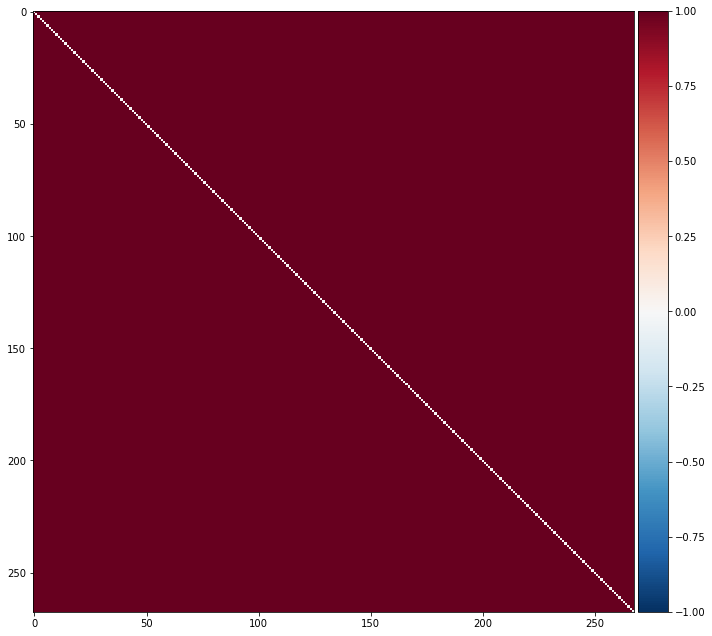

In [7]:
# Stack all conditions
mats = corrmats_aggregated[ok_index]
mats = np.reshape(mats, (mats.shape[0] * mats.shape[1] * mats.shape[2], 
                         mats.shape[3], mats.shape[4]))

# Calculate statistical theshold
pvalues = ttest_1samp(mats, popmean=0).pvalue
pvalues_vec = pvalues[np.triu_indices(n_rois, k=1)]
pvalues_mask = np.zeros((n_rois, n_rois)).astype('bool')
pvalues_mask[np.triu_indices(n_rois, k=1)] = fdrcorrection(
    pvalues_vec, 
    alpha=alpha_fdr)[0]
pvalues_mask = pvalues_mask + pvalues_mask.T

# Apply mask
corrmats_aggregated_statthr = corrmats_aggregated * pvalues_mask

# Remove remaininng negative connections
corrmats_aggregated_fullthr = corrmats_aggregated_statthr 
# corrmats_aggregated_fullthr = (corrmats_aggregated_statthr 
#                                * (corrmats_aggregated_statthr > 0))

# Calculate basic thresholding statistics
perc_nonzero = perc_connections(
    corrmats_aggregated, lambda x: (x>0)|(x<0), non_network_dims=[0, 1, 2])
perc_positive = perc_connections(
    corrmats_aggregated, lambda x: x>0, non_network_dims=[0, 1, 2])
perc_negative = perc_connections(
    corrmats_aggregated, lambda x: x<0, non_network_dims=[0, 1, 2])


perc_statthr_retained = perc_connections(pvalues_mask, lambda x: x)
perc_statthr_positive = perc_connections(
    corrmats_aggregated_statthr, lambda x: x>0, non_network_dims=[0, 1, 2])
perc_statthr_negative = perc_connections(
    corrmats_aggregated_statthr, lambda x: x<0, non_network_dims=[0, 1, 2])

perc_fullthr_nonzero = perc_connections(
    corrmats_aggregated_fullthr, lambda x: (x>0)|(x<0), non_network_dims=[0, 1, 2])
perc_fullthr_positive = perc_connections(
    corrmats_aggregated_fullthr, lambda x: x>0, non_network_dims=[0, 1, 2])
perc_fullthr_negative = perc_connections(
    corrmats_aggregated_fullthr, lambda x: x<0, non_network_dims=[0, 1, 2])


print('Raw corrmats'.center(40, '='))
print(f'Nonzero connections:\n\t{perc_nonzero*100:.2f}%')
print(f'Positive connections:\n\t{perc_positive*100:.2f}%')
print(f'Negative connections:\n\t{perc_negative*100:.2f}%\n')
print('Stat thr. corrmats'.center(40, '='))
print(f'Retained connections:\n\t{perc_statthr_retained*100:.2f}%')
print(f'Positive connections:\n\t{perc_statthr_positive*100:.2f}%')
print(f'Negative connections:\n\t{perc_statthr_negative*100:.2f}%\n')
print('Full thr. corrmats'.center(40, '='))
print(f'Nonzero connections:\n\t{perc_fullthr_nonzero*100:.2f}%')
print(f'Positive connections:\n\t{perc_fullthr_positive*100:.2f}%')
print(f'Negative connections:\n\t{perc_fullthr_negative*100:.2f}%')

plot_matrix(pvalues_mask)

### Calculate measures

In [8]:
m_aggregated = np.zeros((n_subjects, n_conditions, n_perr_sign, n_rois))
q_aggregated = np.zeros((n_subjects, n_conditions, n_perr_sign))
z_aggregated = np.zeros((n_subjects, n_conditions, n_perr_sign, n_rois))
p_aggregated = np.zeros((n_subjects, n_conditions, n_perr_sign, n_rois))

for sub_idx, con_idx, perr_sign_idx in tqdm(list(product(range(n_subjects), 
                                                         range(n_conditions), 
                                                         range(n_perr_sign)))):

    corrmat = corrmats_aggregated_fullthr[sub_idx, con_idx, perr_sign_idx]
    corrmat[np.diag_indices_from(corrmat)] = 0
    
    best_q = 0 
    for _ in range(louvain_reps):
        m, q = community_louvain(corrmat, gamma=louvain_gamma, B=louvain_B)
        if q > best_q:
            best_m = m
            best_q = q
    
    # Within-module degree z-score
    z_aggregated[sub_idx, con_idx, perr_sign_idx] = module_degree_zscore(
        W=corrmat, 
        ci=best_m, 
        flag=0
    )
    
    # Participation coefficient
    p_aggregated[sub_idx, con_idx, perr_sign_idx] = participation_coef(
        W=corrmat,
        ci=best_m,
        degree="undirected"
    )

    # Store best values
    m_aggregated[sub_idx, con_idx, perr_sign_idx] = best_m
    q_aggregated[sub_idx, con_idx, perr_sign_idx] = best_q



suffix = f"gamma_{louvain_gamma_str}_fdrthr_{alpha_fdr_str}"
    
np.save(join(path_out_measures, f"m_aggregated.npy"), m_aggregated)
np.save(join(path_out_measures, f"q_aggregated.npy"), q_aggregated)
np.save(join(path_out_measures, f"z_aggregated.npy"), z_aggregated)
np.save(join(path_out_measures, f"p_aggregated.npy"), p_aggregated)
np.save(join(path_out, f"pvalues_mask.npy"), pvalues_mask)

  0%|          | 0/128 [00:00<?, ?it/s]

/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/bct/algorithms/centrality.py:661: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)
